# 2025-04-14 Multigrid ctd

## Last time

* Multigrid
  * Spectral perspective

  
## Today

* [Additional course resource](https://www.wias-berlin.de/people/john/LEHRE/MULTIGRID/multigrid.pdf)
* Contribution proposals: deadline extended to Wednesday, 04/16
* Continue spectral perspective
* Multigrid: factorization perspective


# Request an RC account

https://www.colorado.edu/rc

* This gives ssh login access. We’ll use Alpine, which is a modern CPU and GPU cluster.
* This will be good for benchmarking and larger runs. We’ll also use GPUs later in class.

## PETSc

* We’ll start using PETSc on Wednesday.
* You can build PETSc on your laptop. You’ll need C development tools.
    * Linux: use package manager (apt install, dnf install, …)
    * OSX: install xcode, many people like homebrew as a package manager
    * Windows: WSL then follow Linux instructions (or MSYS2 or Cygwin)
    * Any: install Docker, then use our image


In [3]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function laplace1d(n)
    "1D Laplacion with Dirichlet boundary conditions eliminated"
    h = 2 / (n + 1)
    x = LinRange(-1, 1, n+2)[2:end-1]
    A = diagm(0 => ones(n),
        -1 => -.5*ones(n-1),
        +1 => -.5*ones(n-1))
    x, A # Hermitian(A) xyz
end

function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

function plot_symbol(S, deriv=2; plot_ref=true, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    if plot_ref
        plot!(fig, th -> th^deriv, label="exact")
    end
    fig
end

function interpolate(m, stride=2)
    s1 = (stride - 1) / stride
    s2 = (stride - 2) / stride
    P = diagm(0 => ones(m),
        -1 => s1*ones(m-1), +1 => s1*ones(m-1),
        -2 => s2*ones(m-2), +2 => s2*ones(m-2))
    P[:, 1:stride:end]
end
#n = 50; x, A = laplace1d(n)
#P = interpolate(n, 2)
#plot(x, P[:, 4:6], marker=:auto, xlims=(-1, 0))
    
ns = 2 .^ (2:8)
eigs = vcat([eigvals(laplace1d(n)[2])[[1, end]] for n in ns]'...)
conds = vcat([cond(laplace1d(n)[2]) for n in ns]'...)

7-element Vector{Float64}:
     9.472135954999578
    32.16343747752639
   116.46119157748709
   440.68856038364817
  1711.661375825713
  6743.676611188256
 26767.984769400602

# Fourier analysis perspective

* Consider the basis $\phi(x, \theta) = e^{i \theta x}$. 
* **Question**: If we have a discrete signal $\{x_i\}_{i=1}^n = x_1, x_2, \ldots, x_n$, what does the highest frequency, amplitude-1 signal possible look like?

* It would be $1, -1, 1, -1, \ldots$. Therefore 
* If we choose the grid $x \in h \mathbb Z$ with grid size $h$ then we can resolve frequencies $\lvert \theta \rvert \le \pi/h$.

* Symbol recap: Let $\phi(x, \theta) = e^{i\theta x}$ be an input signal we apply the stencil (i.e. differentiation rule = nodes + weights) $S$ to, e.g. 
$$ S\phi(x, \theta) = s_{-1}\phi(x-1, \theta) + s_0\phi(x, \theta) + s_1\phi(x+1, \theta) := \hat{S}(\theta) \phi(x, \theta)   $$
* Then $\hat{S}(\theta)$ is the symbol. 
* **Question**: what are the eigenvalues?

In [1]:
function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

function plot_symbol(S, deriv=2; plot_ref=true, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    if plot_ref
        plot!(fig, th -> th^deriv, label="exact")
    end
    fig
end

plot_symbol (generic function with 2 methods)

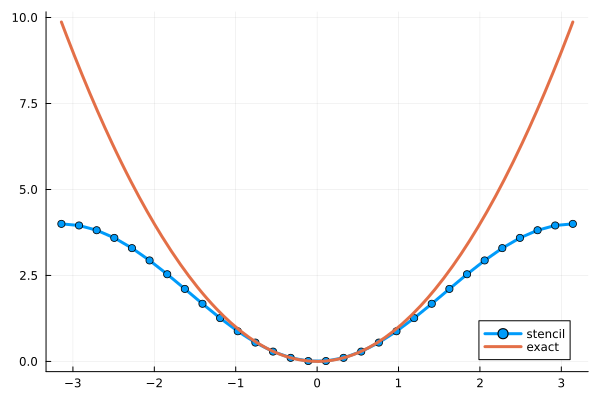

In [4]:
plot_symbol([1 -2 1])
#plot!(xlims=(-1, 1))

# Analytically computing smallest eigenvalue

* The longest wavelength for a domain size of 2 with Dirichlet boundary conditions is 4. 
* The frequency is $\theta = 2\pi/\lambda = \pi/2$. The `symbol` function works on an integer grid. We can transform via $\theta \mapsto \theta h$.
* We can read off the lowest eigenvalue easily

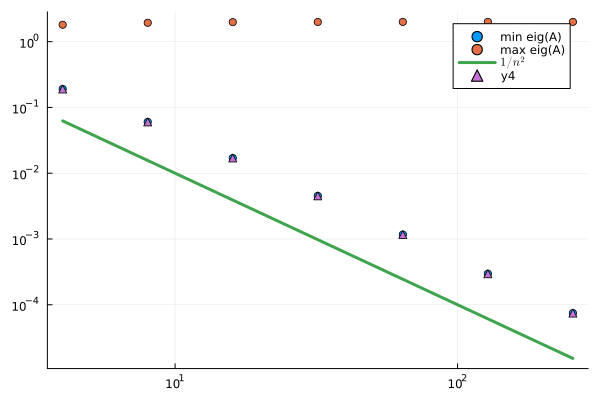

In [5]:
scatter(ns, eigs, label=["min eig(A)" "max eig(A)"])
plot!(n -> 1/n^2, label="\$1/n^2\$", xscale=:log10, yscale=:log10)
theta_min = pi ./ (ns .+ 1)
symbol_min = -real(symbol([1 -2 1], theta_min))
scatter!(ns, symbol_min / 2, shape=:utriangle)

# Damping properties of Richardson(/Jacobi) relaxation

- Recall: we can solve a linear system $Ax = b$ with the following iteration (Richardson iteration):
$$  x^{(k+1)}=x^{(k)}+\omega \left(b-Ax^{(k)}\right) $$
- Convergence rate is 
$$  e^{(k+1)}=e^{(k)}-\omega Ae^{(k)}=(I-\omega A)e^{(k)} $$
- We therefore would like for $I - w A$ to have a small norm, such that powers (repeat iterations) will cause the error to decay rapidly.

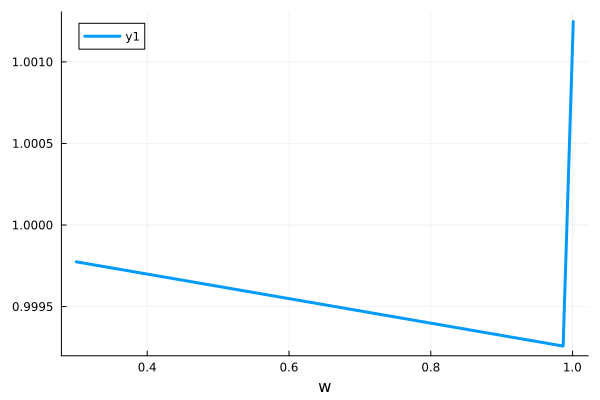

In [6]:
x, A = laplace1d(80)
ws = LinRange(.3, 1.001, 50)
radius = [opnorm(I - w*A) for w in ws] # Note opnorm = operator norm.
plot(ws, radius, xlabel="w")

* The spectrum of $A$ runs from $\theta_{\min}^2$ up to 2.  If $w > 1$, then $\lVert I - w A \rVert > 1$ because the operation amplifies the high frequencies (associated with the eigenvalue of 2).
* The value of $w$ that minimizes the norm is slightly less than 1, but the convergence rate is very slow (only barely less than 1). We've seen this in numerical experiments!

# Symbol of damping

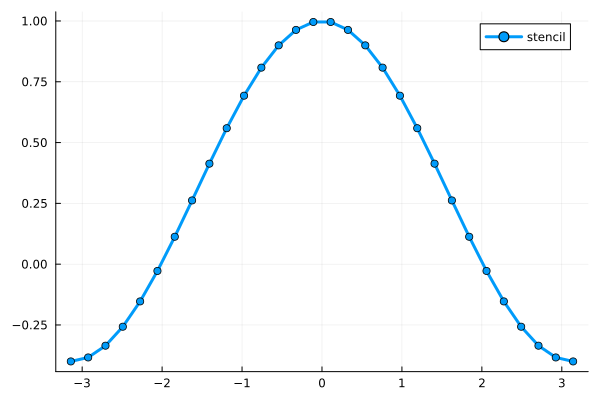

In [7]:
w = .7
plot_symbol([0 1 0] - w * [-.5 1 -.5], 0; plot_ref=false)

* Evidently it is very difficult to damp low frequencies.
* This makes sense because $A$ and $I - wA$ move information only one grid point per iteration.
* It also makes sense because the polynomial needs to be 1 at the origin, and the low frequencies have eigenvalues very close to zero.

* What did that last point mean? Recall that
    * Equivalently to finding $\omega$ such that $||I - \omega A||$ is minimized, we may seek a monic polynomial $p(z) = 1 - \omega z$ that minimizes 
    $$ \max_{\lambda \in \sigma(A)} |p(\lambda)| $$
    * This poly is $1$ at the origin, which is where the low-frequency eigenfunctions are.
 

# Coarse grids: turning low frequencies into high frequencies

As in domain decomposition, we will express our "coarse" subspace, consisting of a grid $x \in 2h\mathbb Z$, in terms of its interpolation to the fine space.  Here, we'll use linear interpolation.

(100, 50)

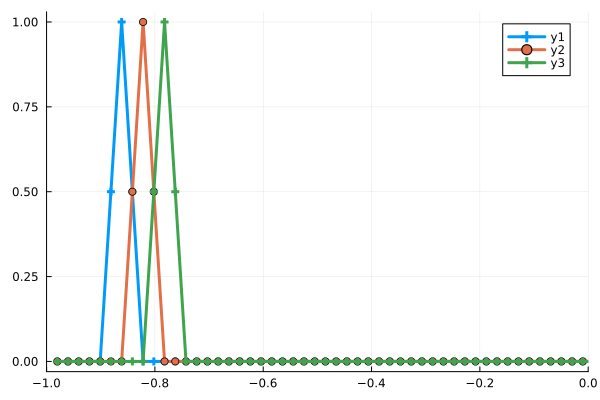

In [8]:
# Question: what does this code do?
function interpolate(m, stride=2)
    s1 = (stride - 1) / stride
    s2 = (stride - 2) / stride
    P = diagm(0 => ones(m),
        -1 => s1*ones(m-1), +1 => s1*ones(m-1),
        -2 => s2*ones(m-2), +2 => s2*ones(m-2))
    P[:, 1:stride:end]
    # Ignore normalization, we'll multiply this by a constant factor later!
end
n = 100; x, A = laplace1d(n)
P = interpolate(n, 2)
print(size(P))
plot(x, P[:, 4:6], marker=:auto, xlims=(-1, 0))

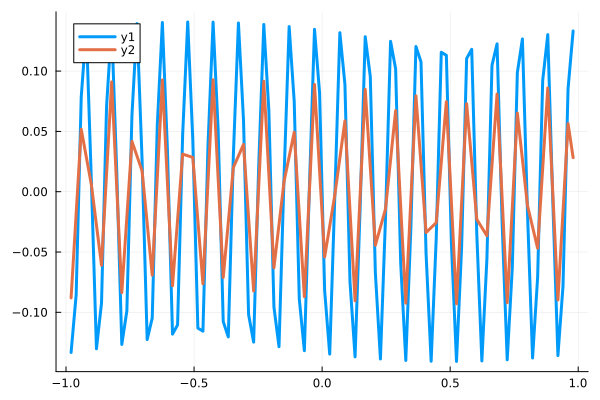

In [9]:
L, X = eigen(A)
u_h = X[:, 40]
u_2h = .5 * P' * u_h # Here's the normalization factor.
plot(x, [u_h, P * u_2h])

# Galerkin approximation of $A$ in coarse space

$$ A_{2h} u_{2h} = P^T A_h P u_{2h} $$

size(A) = (100, 100)
size(A_2h) = (50, 50)


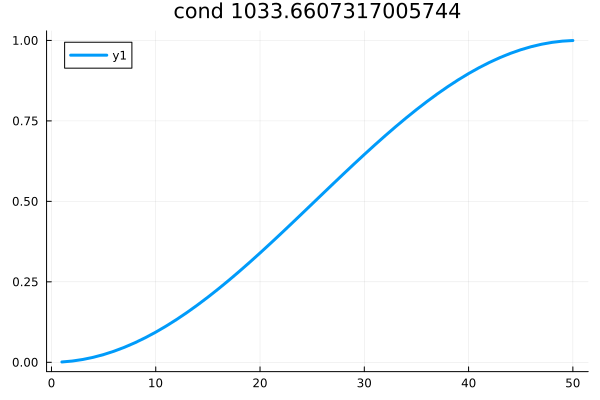

In [10]:
n = 100
x, A = laplace1d(n)
P = interpolate(n)
@show size(A)
A_2h = P' * A * P
@show size(A_2h)
L_2h = eigvals(A_2h)
plot(L_2h, title="cond $(L_2h[end]/L_2h[1])")

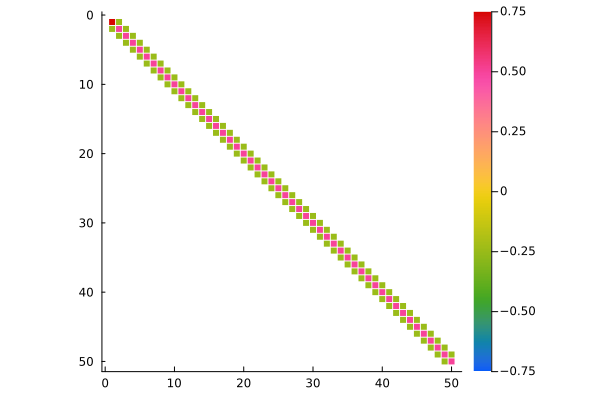

In [11]:
my_spy(A_2h)

# Coarse grid correction

Consider the $A$-orthogonal projection onto the range of $P$,
$$ S_c = P A_{2h}^{-1} P^T A $$

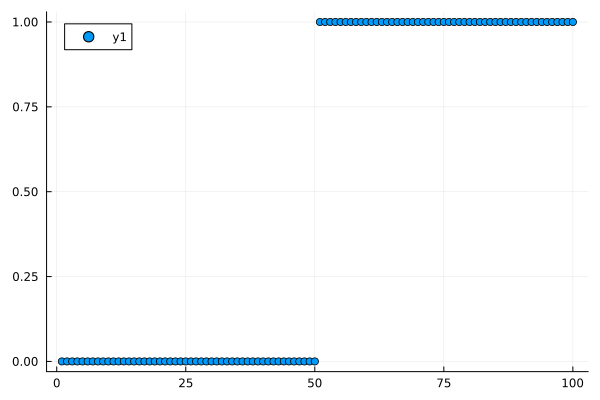

In [12]:
Sc = P * (A_2h \ P' * A)
Ls, Xs = eigen(I - Sc)
scatter(real.(Ls))

* This spectrum is typical for a projector. If $u$ is in the range of $P$, then $S_c u = u$. Why?
* For all vectors $v$ that are $A$-orthogonal to the range of $P$, we know that $S_c v = 0$. Why?

# A two-grid method

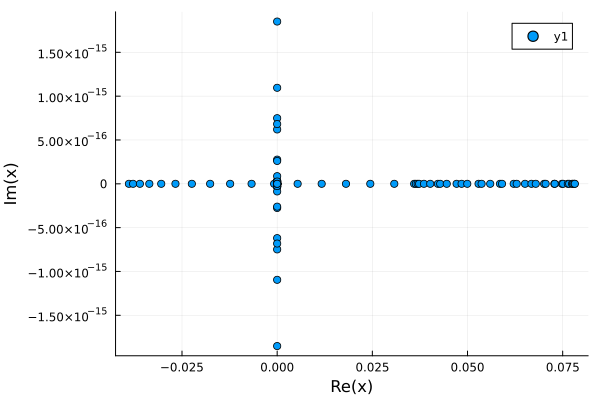

In [13]:
w = .67
T = (I - w*A)^1 * (I - Sc) * (I - w*A)^2
Lt = eigvals(T)
scatter(Lt)

* Can analyze these methods in terms of frequency.
* [LFAToolkit](https://jeremylt.github.io/LFAToolkit.jl/stable/examples/diffusion/#Diffusion-operator)